In [1]:
import pandas as pd
df = pd.read_csv('monaco_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:36:02.319000,LEC,16,0 days 00:40:56.330000,1.0,1.0,NaN,0 days 00:56:45.433000,NaN,0 days 00:00:46.389000,...,True,Ferrari,0 days 00:55:05.680000,2024-05-26 13:03:11.069,1254,1.0,False,NaN,False,False
1,0 days 01:39:00.140000,LEC,16,NaN,2.0,2.0,0 days 01:36:03.182000,NaN,0 days 00:00:26.854000,0 days 00:00:41.743000,...,True,Ferrari,0 days 01:35:54.733000,2024-05-26 13:44:00.122,14,1.0,False,NaN,False,False
2,0 days 01:40:24.764000,LEC,16,0 days 00:01:24.624000,3.0,2.0,NaN,NaN,0 days 00:00:24.007000,0 days 00:00:38.235000,...,True,Ferrari,0 days 01:39:00.140000,2024-05-26 13:47:05.529,1,1.0,False,NaN,False,True
3,0 days 01:41:47.389000,LEC,16,0 days 00:01:22.625000,4.0,2.0,NaN,NaN,0 days 00:00:21.892000,0 days 00:00:38.779000,...,True,Ferrari,0 days 01:40:24.764000,2024-05-26 13:48:30.153,1,1.0,False,NaN,False,True
4,0 days 01:43:09.184000,LEC,16,0 days 00:01:21.795000,5.0,2.0,NaN,NaN,0 days 00:00:21.314000,0 days 00:00:38.513000,...,True,Ferrari,0 days 01:41:47.389000,2024-05-26 13:49:52.778,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,0 days 03:19:16.767000,ZHO,24,0 days 00:01:17.173000,76.0,3.0,NaN,NaN,0 days 00:00:20.460000,0 days 00:00:35.927000,...,True,Kick Sauber,0 days 03:17:59.594000,2024-05-26 15:26:04.983,1,16.0,False,NaN,False,True
1233,0 days 01:36:02.319000,OCO,31,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,True,Alpine,0 days 00:55:05.680000,2024-05-26 13:03:11.069,1254,NaN,False,NaN,True,False
1234,0 days 01:36:02.319000,PER,11,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,True,Red Bull Racing,0 days 00:55:05.680000,2024-05-26 13:03:11.069,1254,NaN,False,NaN,True,False
1235,0 days 01:36:02.319000,HUL,27,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,True,Haas F1 Team,0 days 00:55:05.680000,2024-05-26 13:03:11.069,1254,NaN,False,NaN,True,False


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 78  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              1               2.0          38.500000   
1    ALO              1               2.0          38.000000   
2    BOT              2               2.0          25.333333   
3    GAS              1               2.0          38.500000   
4    HAM              2               2.0          26.000000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0               0.0          0.012987         0.987013  
1               0.0          0.986842         0.013158  
2               0.0          0.184211         0.815789  
3               0.0          0.987013         0.012987  
4               0.0          0.641026         0.358974  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,1.0,0 days 00:57:00.668000,NaN,MEDIUM,1.0,1.0
1,ALB,2.0,NaN,0 days 01:36:41.722000,HARD,1.0,2.0
2,ALO,1.0,0 days 00:57:10.782000,NaN,HARD,2.0,1.0
3,ALO,2.0,NaN,0 days 01:37:00.031000,MEDIUM,2.0,2.0
4,BOT,1.0,0 days 00:57:14.608000,NaN,HARD,1.0,1.0
5,BOT,2.0,NaN,0 days 01:37:08.441000,MEDIUM,1.0,2.0
6,BOT,15.0,0 days 01:56:52.474000,NaN,MEDIUM,14.0,2.0
7,BOT,16.0,NaN,0 days 01:57:16.741000,HARD,2.0,3.0
8,GAS,1.0,0 days 00:57:02.934000,NaN,HARD,1.0,1.0
9,GAS,2.0,NaN,0 days 01:36:44.525000,MEDIUM,1.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,2.0,38.500000,0.000000,0.012987,0.987013
1,ALO,1,2.0,38.000000,0.000000,0.986842,0.013158
2,BOT,2,2.0,25.333333,0.000000,0.184211,0.815789
3,GAS,1,2.0,38.500000,0.000000,0.987013,0.012987
4,HAM,2,2.0,26.000000,0.000000,0.641026,0.358974
5,HUL,0,0.0,1.000000,0.000000,1.000000,0.000000
6,LEC,1,2.0,39.000000,0.000000,0.012821,0.987179
7,MAG,0,0.0,1.000000,0.000000,0.000000,1.000000
8,NOR,1,2.0,39.000000,0.000000,0.012821,0.987179
9,OCO,0,0.0,1.000000,0.000000,0.000000,1.000000


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1187


In [9]:
df['Driver'].value_counts()


,count
Driver,
LEC,76
PIA,76
SAI,76
NOR,76
RUS,76
TSU,75
GAS,75
ALB,75
HAM,74


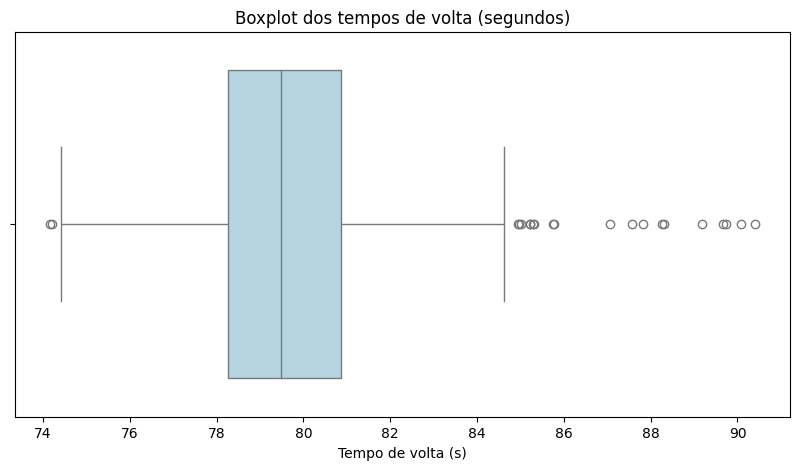

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


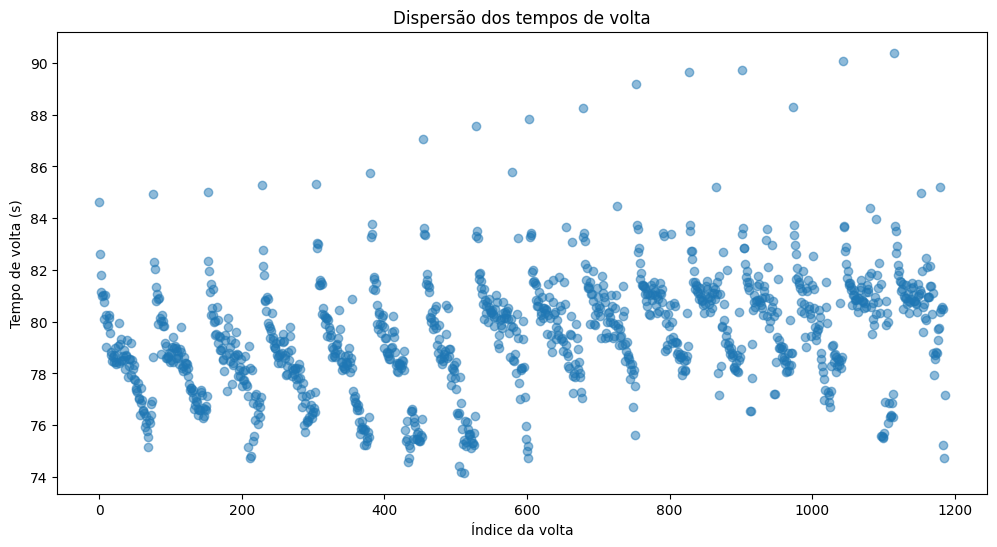

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


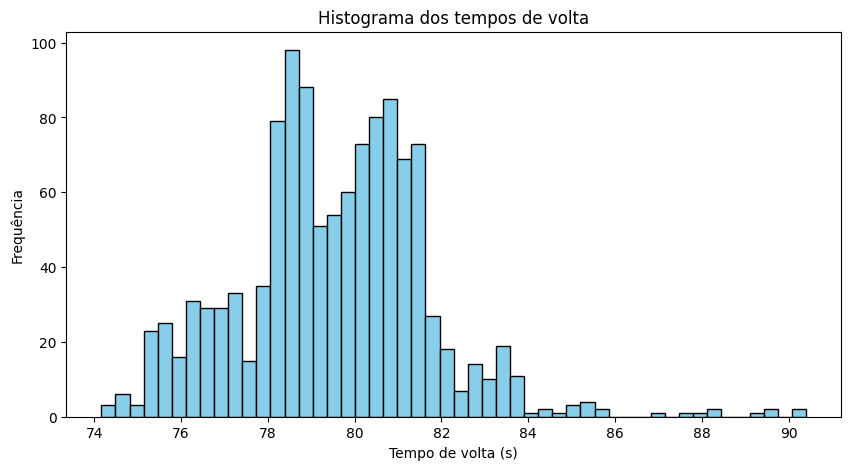

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


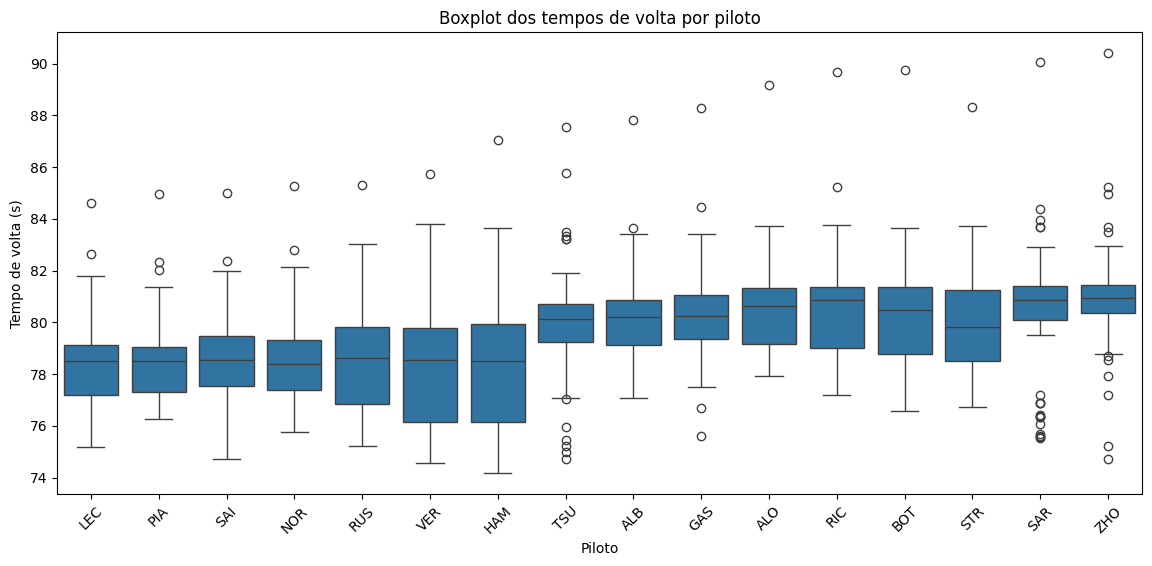

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
HAM   0 days 00:01:14.165000
VER   0 days 00:01:14.569000
ZHO   0 days 00:01:14.718000
TSU   0 days 00:01:14.720000
SAI   0 days 00:01:14.726000
LEC   0 days 00:01:15.162000
RUS   0 days 00:01:15.228000
SAR   0 days 00:01:15.525000
GAS   0 days 00:01:15.625000
NOR   0 days 00:01:15.742000
PIA   0 days 00:01:16.281000
BOT   0 days 00:01:16.561000
STR   0 days 00:01:16.710000
ALB   0 days 00:01:17.060000
RIC   0 days 00:01:17.172000
ALO   0 days 00:01:17.939000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Monaco'
race_date = '2024-05-26'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,75,80.167120,1.736434,77.060,87.834,80.2220,10.774,2024,Monaco,2024-05-26
1,ALO,74,80.562878,1.762615,77.939,89.188,80.6390,11.249,2024,Monaco,2024-05-26
2,BOT,72,80.333681,2.026370,76.561,89.743,80.4935,13.182,2024,Monaco,2024-05-26
3,GAS,75,80.246427,1.768971,75.625,88.269,80.2290,12.644,2024,Monaco,2024-05-26
4,HAM,74,78.363986,2.529303,74.165,87.058,78.5100,12.893,2024,Monaco,2024-05-26
5,LEC,76,78.439039,1.698524,75.162,84.624,78.5000,9.462,2024,Monaco,2024-05-26
6,NOR,76,78.532842,1.691592,75.742,85.283,78.3995,9.541,2024,Monaco,2024-05-26
7,PIA,76,78.524145,1.589224,76.281,84.953,78.4860,8.672,2024,Monaco,2024-05-26
8,RIC,74,80.568959,1.875903,77.172,89.656,80.8445,12.484,2024,Monaco,2024-05-26
9,RUS,76,78.589645,2.107820,75.228,85.319,78.6375,10.091,2024,Monaco,2024-05-26


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,75,80.167120,1.736434,77.060,87.834,80.2220,10.774,2024,Monaco,2024-05-26,77.0,True
1,ALO,74,80.562878,1.762615,77.939,89.188,80.6390,11.249,2024,Monaco,2024-05-26,76.0,True
2,BOT,72,80.333681,2.026370,76.561,89.743,80.4935,13.182,2024,Monaco,2024-05-26,76.0,True
3,GAS,75,80.246427,1.768971,75.625,88.269,80.2290,12.644,2024,Monaco,2024-05-26,77.0,True
4,HAM,74,78.363986,2.529303,74.165,87.058,78.5100,12.893,2024,Monaco,2024-05-26,78.0,True
5,LEC,76,78.439039,1.698524,75.162,84.624,78.5000,9.462,2024,Monaco,2024-05-26,78.0,True
6,NOR,76,78.532842,1.691592,75.742,85.283,78.3995,9.541,2024,Monaco,2024-05-26,78.0,True
7,PIA,76,78.524145,1.589224,76.281,84.953,78.4860,8.672,2024,Monaco,2024-05-26,78.0,True
8,RIC,74,80.568959,1.875903,77.172,89.656,80.8445,12.484,2024,Monaco,2024-05-26,76.0,True
9,RUS,76,78.589645,2.107820,75.228,85.319,78.6375,10.091,2024,Monaco,2024-05-26,78.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,2.0,38.500000,0.000000,0.012987,0.987013
1,ALO,1,2.0,38.000000,0.000000,0.986842,0.013158
2,BOT,2,2.0,25.333333,0.000000,0.184211,0.815789
3,GAS,1,2.0,38.500000,0.000000,0.987013,0.012987
4,HAM,2,2.0,26.000000,0.000000,0.641026,0.358974
5,HUL,0,0.0,1.000000,0.000000,1.000000,0.000000
6,LEC,1,2.0,39.000000,0.000000,0.012821,0.987179
7,MAG,0,0.0,1.000000,0.000000,0.000000,1.000000
8,NOR,1,2.0,39.000000,0.000000,0.012821,0.987179
9,OCO,0,0.0,1.000000,0.000000,0.000000,1.000000


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,75,80.167120,1.736434,77.060,87.834,80.2220,10.774,2024,Monaco,2024-05-26,77.0,True,1,2.0,38.500000,0.000000,0.012987,0.987013
1,ALO,74,80.562878,1.762615,77.939,89.188,80.6390,11.249,2024,Monaco,2024-05-26,76.0,True,1,2.0,38.000000,0.000000,0.986842,0.013158
2,BOT,72,80.333681,2.026370,76.561,89.743,80.4935,13.182,2024,Monaco,2024-05-26,76.0,True,2,2.0,25.333333,0.000000,0.184211,0.815789
3,GAS,75,80.246427,1.768971,75.625,88.269,80.2290,12.644,2024,Monaco,2024-05-26,77.0,True,1,2.0,38.500000,0.000000,0.987013,0.012987
4,HAM,74,78.363986,2.529303,74.165,87.058,78.5100,12.893,2024,Monaco,2024-05-26,78.0,True,2,2.0,26.000000,0.000000,0.641026,0.358974
5,LEC,76,78.439039,1.698524,75.162,84.624,78.5000,9.462,2024,Monaco,2024-05-26,78.0,True,1,2.0,39.000000,0.000000,0.012821,0.987179
6,NOR,76,78.532842,1.691592,75.742,85.283,78.3995,9.541,2024,Monaco,2024-05-26,78.0,True,1,2.0,39.000000,0.000000,0.012821,0.987179
7,PIA,76,78.524145,1.589224,76.281,84.953,78.4860,8.672,2024,Monaco,2024-05-26,78.0,True,1,2.0,39.000000,0.000000,0.012821,0.987179
8,RIC,74,80.568959,1.875903,77.172,89.656,80.8445,12.484,2024,Monaco,2024-05-26,76.0,True,1,2.0,38.000000,0.000000,0.013158,0.986842
9,RUS,76,78.589645,2.107820,75.228,85.319,78.6375,10.091,2024,Monaco,2024-05-26,78.0,True,1,2.0,39.000000,0.000000,0.987179,0.012821


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (16, 19)
Pilotos presentes: 16


In [23]:
df_completo.to_csv('df_completoMonaco.csv', index=False)
